# A new characterisation of convex order using the 2-Wasserstein distance 
##  -- Implementation of numerical examples in Section 4 of the paper --

**Authors: Johannes Wiesel and Erica Zhang**

**Version: July 18, 2022**

*Columbia University, Department of Statistics*

### Introduction

Given two distributions $\mu$ and $\nu$, we solve the optimisation problem

\begin{align*}
V(\mu,\nu):=\inf_{\rho\in \mathcal{P}_2^1(\mathbb{R}^d)} \left( C(\nu,\rho)-C(\mu,\rho)\right) \hspace{1cm}(1)
\end{align*}
see Section 4 of the paper. We recall that
\begin{align*}
\mathcal{P}_2^1(\mathbb{R}^d)=\{\rho\in \mathcal{P}_2(\mathbb{R}^d), \ \mathrm{supp}(\rho)\subseteq B_1(0)\}
\end{align*}
and 
\begin{align*}
C(\nu,\rho)&:=-\inf_{\pi\in \Pi(\nu,\rho)} \int -\langle x,y\rangle\, \pi(dx,dy).
\end{align*}
We have the relationship 
\begin{align*}
\mu\preceq_c \nu \quad \Leftrightarrow \quad V(\mu,\nu)\le 0.
\end{align*}

Clearly the numerical performance of $V(\mu,\nu)$ hinges on the exploration of the convex set $\mathcal{P}_2^1(\mathbb{R}^d)$.  We offer four different methods for this, whose implementation can be found in the 'Optimization.py' file:

 - $\textbf{Indirect Dirichlet with histograms}$: iteratively draw a Dirichlet random variable to select one probability measure $\rho\in \mathcal{P}_2^1(\mathbb{R}^d)$ supported on a grid of $B_1(0)$. Compute $(C(\nu,\rho)-C(\mu,\rho))$ using the histograms of $\mu,\nu,\rho$. Then minimise over $\rho$ to find $V(\mu,\nu)$. 
 - $\textbf{Indirect Dirichlet with samples}$: iteratively draw a Dirichlet random variable to select one probability measure $\rho\in \mathcal{P}_2^1(\mathbb{R}^d)$ supported on a grid of $B_1(0)$. Compute $(C(\nu,\rho)-C(\mu,\rho))$ using samples of $\mu,\nu,\rho$. Then minimise over $\rho$ to find $V(\mu,\nu)$. 
 - $\textbf{Direct randomized Dirichlet}$: draw (signed) Dirichlet samples directly. Use these samples together with samples of $\mu,\nu$ to compute $(C(\nu,\rho)-C(\mu,\rho))$. Then minimise over $\rho$ to find $V(\mu,\nu)$. 
 - $\textbf{Direct Dirichlet}$: draw (signed) and independently randomized Dirichlet samples directly. Use these samples together with samples of $\mu,\nu$ to compute $(C(\nu,\rho)-C(\mu,\rho))$. Then minimise over $\rho$ to find $V(\mu,\nu)$. 
 
We compare the results obtained using each method and we also compare and analyze the runtime of each method.

### Rewriting the problem as a linear program

We implement (1) as the linear problem

\begin{align*}
\inf_{\mathbf{\rho}} \big( \inf_{\pi_\mu} \langle \pi_\mu, \mathbf{M_\mu} \rangle_{\textit{F}}  -\inf_{\pi_\nu} \langle \pi_\nu, \mathbf{M_\nu} \rangle_{\textit{F}} \big)
\end{align*}

under the constraints
\begin{align*}
\pi_\mu\mathbf{1} &= \mu\\
\pi_\mu^{\textit{T}}\mathbf{1} &= \mathbf{\rho}\\
\pi_\nu \mathbf{1} &= \nu\\
\pi_\nu^{\textit{T}}\mathbf{1} &= \mathbf{\rho}\\
\pi_\mu,\pi_\nu &\geq 0,
\end{align*}

where we used the notation:
- $M_\mu$ is the negative inner product matrix between samples of $\mu$ and $\rho$, see the definition of $C(\mu,\rho)$.
- $M_\nu$ is the negative inner product matrix between samples of $\nu$ and $\rho$, see the definition of $C(\nu,\rho)$.
- $\mu,\nu,\rho$ are vectors representing sample weights.
 

### Note

Since the algorithms from the "Optimization.py" file have a high time-complexity, the code chunk for generating lists of $V(\mu,\nu)$ for each example takes approximately 20 minutes. This runtime increases linearly with a higher value of parameter $g$ and exponentially (for $d > 1$) with a higher value of parameter $p$. Furhtermore, depending on the choice of the parameters $p,g$, the graphs may slightly differ from those in the paper.

Furthermore, throughout this document we have set the alpha sampling method to be  "random generation" by default. Other systematic alpha generating methods in the 'generate_alpha.py' file are not tested here. 

### Import Dependencies 

In [ ]:
# 0.1 general packages
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
import scipy as scipy 
from scipy.stats import dirichlet
from ot.datasets import make_2D_samples_gauss as gauss2
import math
from numpy import random
from scipy import stats
from itertools import product
from scipy.spatial.distance import cdist
# 0.2 runtime package
import time
# 0.3 helper packages
from Histograms import *
from Optimization import *
# 0.4 table package
from tabulate import tabulate

### Plot Example 4.1 for $d=1$

We first take $d = 1$ and consider the two distributions $\mu = \mathcal{N}(0,\sigma^2)$ and $\nu = \mathcal{N}(0, 1)$, where the variance $\sigma^2$ varies in the interval $[0,2]$. We then plot $V(\mu,\nu)$ as a function of $\sigma^2$.

More specifically, for a fixed sample size $n$, we plot the sample mean of $V(\mu,\nu)$ obtained through each of the four optimization sampling methods described above with a filled-in 95% confidence band.

First, we generate a list of:

 - $V(\mu,\nu)$ obtained through "Indirect Dirichlet with histograms", "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 - 95% confidence interval for "Indirect Dirichlet with histograms", "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 - runtime for "Indirect Dirichlet with histograms", "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 

In [ ]:
# source_a size is size_a
size_a = 100
# source_b size is size_b
size_b = 100
# target_size for rho is target_size
target_size = 100
# parition size for variance is g: partition the variance grid into 'g' equal parts
g = 5
# sampling size
n = 3
# x-axis (variance): here we start at 0.1 since variance = 0 incurs calculation problems with the 1D gaussian histogram
x = np.linspace(0.1,2,g)
# partition size of rho's support for non-dirichlet methods
p = 3
# method for choosing the dirichlet parameter alpha
method = "random"


# source_b histogram
b_result = gauss1D(size_b,0,1)
b_hist = b_result[1]
# source_b grid
b_grid = b_result[0]
# source_b samples
b_samples = np.random.normal(0, 1, size=size_b)
# source_a grid
a_grid = np.arange(size_a, dtype=np.float64)-size_a/2 

# create lists
y_hist = []
ci_lower_hist = []
ci_upper_hist = []
y_samples = []
ci_lower_samples = []
ci_upper_samples = []
y_dir = []
ci_lower_dir = []
ci_upper_dir = []
y_dir_alt = []
ci_lower_dir_alt = []
ci_upper_dir_alt = []
hist_method_time = []
samples_method_time = []
dir_method_time = []
dir_alt_time = []

for i in range(g):
    a_result = gauss1D(size_a,0,x[i])
    a = a_result[1]
    
    # 1. Histogram Method
    start_time = time.time()
    inf = sample_inference(N = n, a=a,b=b_hist,a_grid = a_grid, b_grid = b_grid, p = p, target_size = target_size, op_method = "Hist", method = method)
    # track runtime
    runtime = time.time() - start_time
    hist_method_time.append(runtime)
    result = inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_hist.append(result)
    ci_lower_hist.append(ci_lower)
    ci_upper_hist.append(ci_upper)
    
    # 2. Samples Method
    a = np.random.normal(0, x[i], size=size_a)  # generate samples for source_a
    start_time = time.time()
    inf = sample_inference(N = n,a=a,b=b_samples, p=p, target_size = target_size, op_method = "Samples", method = method)
    # track runtime
    runtime = time.time() - start_time
    samples_method_time.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_samples.append(result)
    ci_lower_samples.append(ci_lower)
    ci_upper_samples.append(ci_upper)
    
    # 3. Dirichlet (Random Selection) Method
    start_time = time.time()
    inf = sample_inference(N = n, a=a,b=b_samples, target_size = target_size, op_method = "Dirichlet Random", method = method)
    # track runtime
    runtime = time.time() - start_time
    dir_method_time.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_dir.append(result)
    ci_lower_dir.append(ci_lower)
    ci_upper_dir.append(ci_upper)
    
    # 4. Dirichlet Method
    start_time = time.time()
    inf = sample_inference(N = n, a=a,b=b_samples, target_size = target_size, op_method = "Dirichlet", method = method)
    # track runtime
    runtime = time.time() - start_time
    dir_alt_time.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_dir_alt.append(result)
    ci_lower_dir_alt.append(ci_lower)
    ci_upper_dir_alt.append(ci_upper)
    
# conversion to ndarray
y_hist = np.array(y_hist)
ci_lower_hist = np.array(ci_lower_hist)
ci_upper_hist = np.array(ci_upper_hist)
y_samples = np.array(y_samples)
ci_lower_samples = np.array(ci_lower_samples)
ci_upper_samples = np.array(ci_upper_samples)
y_dir = np.array(y_dir)
ci_lower_dir = np.array(ci_lower_dir)
ci_upper_dir = np.array(ci_upper_dir)
y_dir_alt = np.array(y_dir_alt)
ci_lower_dir_alt = np.array(ci_lower_dir_alt)
ci_upper_dir_alt = np.array(ci_upper_dir_alt)
hist_method_time = np.array(hist_method_time)
samples_method_time = np.array(samples_method_time)
dir_method_time = np.array(dir_method_time)
dir_alt_time = np.array(dir_alt_time)

Now we plot $V(\mu,\nu)$ obtained through each of the four optimization sampling methods (y-axis) against (discretized) variance (x-axis).

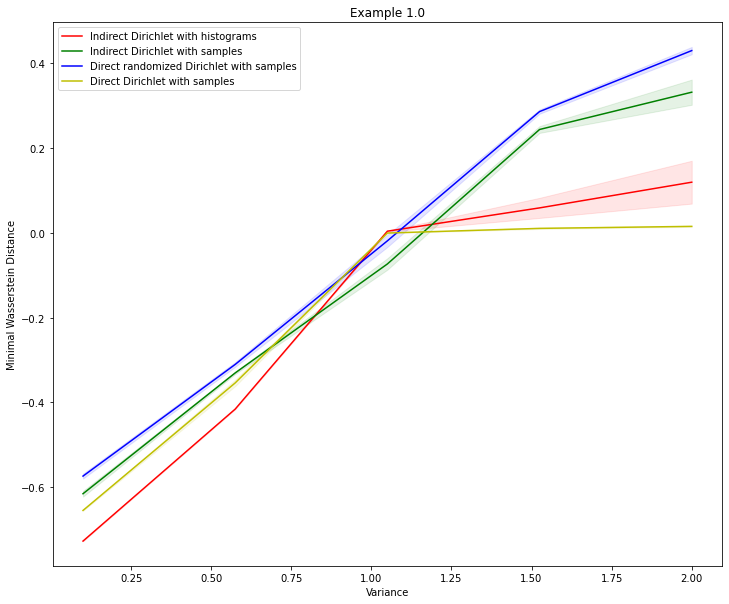

In [ ]:
# Plot four curves in one graph

# Plotting the curves simultaneously
pl.plot(x, y_hist, color='r', label='Indirect Dirichlet with histograms')
# confidence band
pl.fill_between(x, ci_lower_hist, ci_upper_hist, color='r', alpha=.1)
pl.plot(x, y_samples, color='g', label='Indirect Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_samples, ci_upper_samples, color='g', alpha=.1)
pl.plot(x, y_dir, color='b', label='Direct randomized Dirichlet')
# confidence band
pl.fill_between(x, ci_lower_dir, ci_upper_dir, color='b', alpha=.1)
pl.plot(x, y_dir_alt, color='y', label='Direct Dirichlet')
# confidence band
pl.fill_between(x, ci_lower_dir_alt, ci_upper_dir_alt, color='y', alpha=.1)

# Naming the x-axis, y-axis and the whole graph
pl.xlabel("Variance")
pl.ylabel("Value function")
pl.title("Example 4.1 for d=1")

# Adding legend
pl.legend()

# Adjust Size
pl.rcParams['figure.figsize'] = [12, 10]

# load the display window
pl.show()

### Plot Example 4.1 for $d=2$

We now take $d = 2$ and consider $\mu = \mathcal{N}(0,\sigma^2\textit{I})$ and $\nu = \mathcal{N}(0, \textit{I})$ for varying variance $\sigma^2 \in [0,2]$. We again plot $V(\mu,\nu)$ as a function of $\sigma^2$.

More specifically, for a fixed sample size $n$, we plot the sample mean of $V(\mu,\nu)$ obtained through each of the three optimization sampling methods described above with a filled-in 95% confidence band.

First, we generate a list of:

 - $V(\mu,\nu)$ obtained through "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 - 95% confidence interval for "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 - runtime for "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 

In [ ]:
# source_a size is size_a
size_a = 100
# source_b size is size_b
size_b = 100
# target_size for rho is target_size
target_size = 100
# parition size for variance is g: partition the variance grid into 'g' equal parts
g = 5
# sampling size
n = 3
# x-axis (variance): here we start at 0.1 since variance = 0 incurs calculation problems with the 1D gaussian histogram
x = np.linspace(0.1,2,g)
# partition size of rho's support for non-dirichlet methods
p = 3
# method for choosing the dirichlet parameter alpha
method = "random"

# source_b samples
mu_b = np.array([0, 0])
cov_b = np.array([[1, 0], [0, 1]])
b_samples = ot.datasets.make_2D_samples_gauss(size_b, mu_b, cov_b)

# source_a mean is fixed at origin
mu_a = np.array([0, 0])

# create lists
y_samples = []
ci_lower_samples = []
ci_upper_samples = []
y_dir = []
ci_lower_dir = []
ci_upper_dir = []
y_dir_alt = []
ci_lower_dir_alt = []
ci_upper_dir_alt = []
samples_method_time_2 = []
dir_method_time_2 = []
dir_alt_time_2 = []


for i in range(g):
    
    # generate samples for source_a distribution
    cov_a = np.array([[x[i], 0], [0, x[i]]])
    a = ot.datasets.make_2D_samples_gauss(size_a, mu_a, cov_a)    

    # 1. Generate graph for Sample method
    start_time = time.time()
    inf = sample_inference(N = n,a=a,b=b_samples, p=p, target_size = target_size, op_method = "Samples", method = method)
    runtime = time.time() - start_time
    samples_method_time_2.append(runtime)
    #runtime
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_samples.append(result)
    ci_lower_samples.append(ci_lower)
    ci_upper_samples.append(ci_upper)

    # 2. Generate graph for Dirichlet (random selection) method
    start_time = time.time()
    inf = sample_inference(N = n, a=a,b=b_samples, target_size = target_size, op_method = "Dirichlet Random", method = method)
    runtime = time.time() - start_time
    #runtime
    dir_method_time_2.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_dir.append(result)
    ci_lower_dir.append(ci_lower)
    ci_upper_dir.append(ci_upper)


    # 3. Generate graph for Dirichlet (alternative) method
    start_time = time.time()
    inf = sample_inference(N = n, a=a,b=b_samples, target_size = target_size, op_method = "Dirichlet", method = method)
    runtime = time.time() - start_time
    #runtime
    dir_alt_time_2.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_dir_alt.append(result)
    ci_lower_dir_alt.append(ci_lower)
    ci_upper_dir_alt.append(ci_upper)


    
y_samples = np.array(y_samples)
ci_lower_samples = np.array(ci_lower_samples)
ci_upper_samples = np.array(ci_upper_samples)
y_dir = np.array(y_dir)
ci_lower_dir = np.array(ci_lower_dir)
ci_upper_dir = np.array(ci_upper_dir)
y_dir_alt = np.array(y_dir_alt)
ci_lower_dir_alt = np.array(ci_lower_dir_alt)
ci_upper_dir_alt = np.array(ci_upper_dir_alt)
samples_method_time_2 = np.array(samples_method_time_2)
dir_method_time_2 = np.array(dir_method_time_2)
dir_alt_time_2 = np.array(dir_alt_time_2)


Now, we plot $V(\mu,\nu)$ for each of the three optimization sampling methods (y-axis) against (discretized) variance (x-axis).

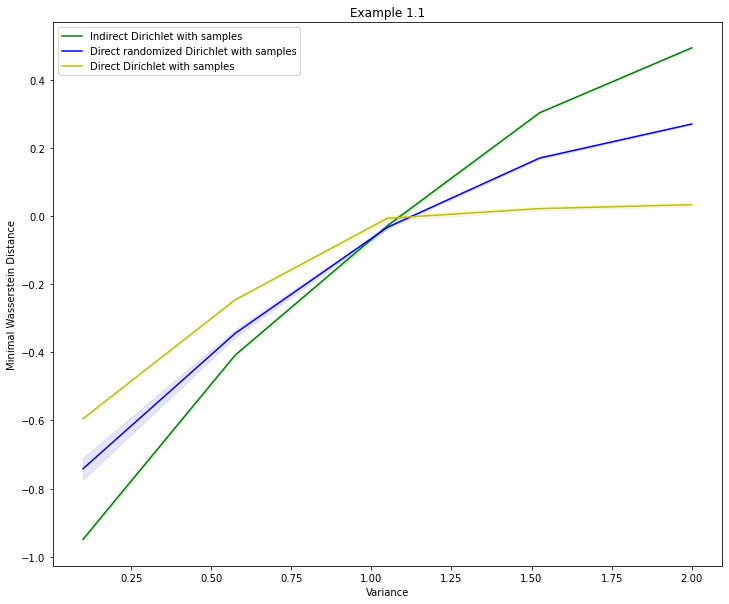

In [ ]:
# Plot three curves in one graph

# Plotting the curves simultaneously
pl.plot(x, y_samples, color='g', label='Indirect Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_samples, ci_upper_samples, color='g', alpha=.1)
pl.plot(x, y_dir, color='b', label='Direct randomized Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_dir, ci_upper_dir, color='b', alpha=.1)
pl.plot(x, y_dir_alt, color='y', label='Direct Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_dir_alt, ci_upper_dir_alt, color='y', alpha=.1)

# Naming the x-axis, y-axis and the whole graph
pl.xlabel("Variance")
pl.ylabel("Value function")
pl.title("Example 4.1 for d=2")

# Adding legend
pl.legend()

# To load the display window
pl.show()

### Plot Example 4.2

We first take $d = 1$ and consider the two distributions $\mu = \frac{1}{2}(\delta_{-1-s}+\delta_{1+s})$ and $\nu = \frac{1}{2}(\delta_{-1}+\delta_{1})$, where the parameter $s$ varies in $[-1,1]$. We then plot $V(\mu,\nu)$ as a function of $s$.

More specifically, for a fixed sample size $n$, we plot the sample mean of $V(\mu,\nu)$ obtained through each of the four optimization sampling methods described above with a filled-in 95% confidence band.

First, we generate a list of:

 - $V(\mu,\nu)$ obtained through "Indirect Dirichlet with histograms", "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 - 95% confidence interval for "Indirect Dirichlet with histograms", "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 - runtime for "Indirect Dirichlet with histograms", "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet"  methods.



In [ ]:
# source_a size is size_a
size_a = 100
# source_b size is size_b
size_b = 100
# target_size for rho is target_size
target_size = 100
# parition size for variance is g: partition the variance grid into 'g' equal parts
g = 5
# sampling size
n = 3
# x-axis
x = np.linspace(-1,1,g)
# partition size of rho's support for non-dirichlet methods
p = 3
# method for choosing the dirichlet parameter alpha
method = "random"

# source_b histogram and grid
result_b = combined_dirac(x = [-1,1], n = size_b)
b_grid = result_b[0]
b_hist = result_b[1]
# source_b samples
b_samples = random.choice([-1,1],size_b)

# create lists
y_hist = []
ci_lower_hist = []
ci_upper_hist = []
y_samples = []
ci_lower_samples = []
ci_upper_samples = []
y_dir = []
ci_lower_dir = []
ci_upper_dir = []
y_dir_alt = []
ci_lower_dir_alt = []
ci_upper_dir_alt = []
hist_method_time_3 = []
samples_method_time_3 = []
dir_method_time_3 = []
dir_alt_time_3 = []


for i in range(g):
    result_a = combined_dirac(x = [-1-x[i],1+x[i]], n = size_a)
    a_grid = result_a[0]
    a = result_a[1]
    
    # 1. Histogram Method
    start_time = time.time()
    inf = sample_inference(N = n, a=a,b=b_hist,a_grid = a_grid, b_grid = b_grid, p=p, target_size = target_size, op_method = "Hist", method = method)
    runtime = time.time() - start_time
    # track runtime
    hist_method_time_3.append(runtime)
    result = inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_hist.append(result)
    ci_lower_hist.append(ci_lower)
    ci_upper_hist.append(ci_upper)

    # 2. Generate graph for Sample method
    a = random.choice([-1-x[i],1+x[i]],size_a) # generate samples for source_a
    start_time = time.time()
    inf = sample_inference(N = n,a=a,b=b_samples, p=p, target_size = target_size, op_method = "Samples", method = method)
    runtime = time.time() - start_time
    # track runtime
    samples_method_time_3.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_samples.append(result)
    ci_lower_samples.append(ci_lower)
    ci_upper_samples.append(ci_upper)


    # 3. Generate graph for Dirichlet (random selection) method
    start_time = time.time()
    inf = sample_inference(N = n, a=a,b=b_samples, target_size = target_size, op_method = "Dirichlet Random", method = method)
    runtime = time.time() - start_time
    # track runtime
    dir_method_time_3.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_dir.append(result)
    ci_lower_dir.append(ci_lower)
    ci_upper_dir.append(ci_upper)


    # 4. Generate graph for Dirichlet (alternative) method
    start_time = time.time()
    inf = sample_inference(N = n, a=a,b=b_samples, target_size = target_size, op_method = "Dirichlet", method = method)
    runtime = time.time() - start_time
    # track runtime
    dir_alt_time_3.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_dir_alt.append(result)
    ci_lower_dir_alt.append(ci_lower)
    ci_upper_dir_alt.append(ci_upper)


y_hist = np.array(y_hist)
ci_lower_hist = np.array(ci_lower_hist)
ci_upper_hist = np.array(ci_upper_hist)
y_samples = np.array(y_samples)
ci_lower_samples = np.array(ci_lower_samples)
ci_upper_samples = np.array(ci_upper_samples)
y_dir = np.array(y_dir)
ci_lower_dir = np.array(ci_lower_dir)
ci_upper_dir = np.array(ci_upper_dir)
y_dir_alt = np.array(y_dir_alt)
ci_lower_dir_alt = np.array(ci_lower_dir_alt)
ci_upper_dir_alt = np.array(ci_upper_dir_alt)
hist_method_time_3 = np.array(hist_method_time)
samples_method_time_3 = np.array(samples_method_time)
dir_method_time_3 = np.array(dir_method_time)
dir_alt_time_3 = np.array(dir_alt_time)

Now, we plot $V(\mu,\nu)$ obtained through each of the four optimization sampling methods (y-axis) against the (discretized) displacement parameter $s$ (x-axis).

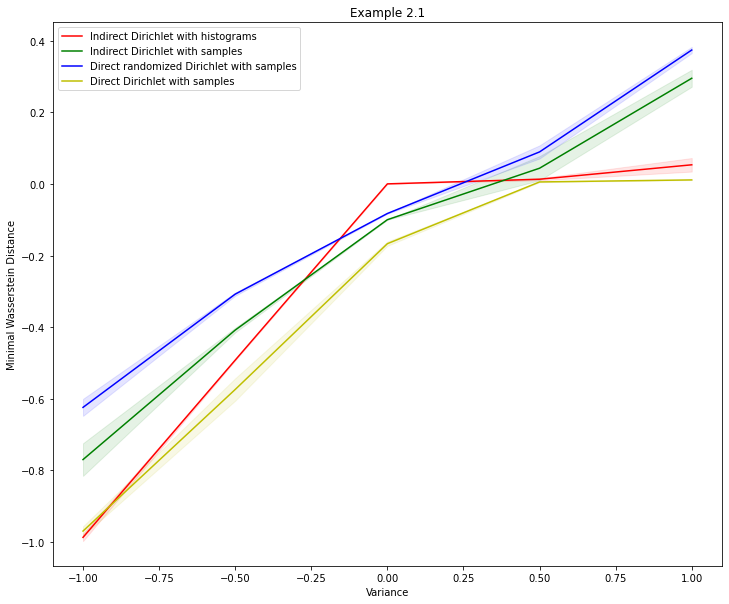

In [ ]:
# Plot four curves in one graph

pl.plot(x, y_hist, color='r', label='Indirect Dirichlet with histograms')
# confidence band
pl.fill_between(x, ci_lower_hist, ci_upper_hist, color='r', alpha=.1)
pl.plot(x, y_samples, color='g', label='Indirect Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_samples, ci_upper_samples, color='g', alpha=.1)
pl.plot(x, y_dir, color='b', label='Direct randomized Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_dir, ci_upper_dir, color='b', alpha=.1)
pl.plot(x, y_dir_alt, color='y', label='Direct Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_dir_alt, ci_upper_dir_alt, color='y', alpha=.1)

# Naming the x-axis, y-axis and the whole graph
pl.xlabel("Displacement parameter s")
pl.ylabel("Value function")
pl.title("Example 4.2")

# Adding legend
pl.legend()

# To load the display window
pl.show()

### Plot Examples 4.3

Lastly we take $d = 2$ and consider  $$\mu= \frac{1}{4} \left( \delta_{(-1-s, 0)} +\delta_{(1+s, 0)}+ \delta_{(0, 1+s)}+ \delta_{(0,-1-s)}\right)$$ and $$\nu = \frac{1}{4}(\delta_{(-1,0)}+\delta_{(1,0)}+\delta_{(0,1)}+\delta_{(0,-1)})$$  for varying parameter $s \in [-1,1]$. We again plot $V(\mu,\nu)$ as a function of $s$.

More specifically, for a fixed sample size $n$, we plot the sample mean of $V(\mu,\nu)$ obtained through each of the three optimization sampling methods described above with a filled-in 95% confidence band.

First, we generate a list of:

 - $V(\mu,\nu)$ obtained through "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 - 95% confidence interval for "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.
 - runtime for "Indirect Dirichlet with samples", "Direct Dirichlet", "Direct randomized Dirichlet" methods.



In [ ]:
# source_a size is size_a
size_a = 100
# source_b size is size_b
size_b = 100
# target_size for rho is target_size
target_size = 100
# parition size for variance is g: partition the variance grid into 'g' equal parts
g = 5
# sampling size
n = 3
# x-axis
x = np.linspace(-1,1,g)
# partition size of rho's support for non-dirichlet methods
p = 3
# method for choosing the dirichlet parameter alpha
method = "random"


# source_b support
b_ls = np.array([[-1,0],[1,0],[0,1],[0,-1]])
# uniform distribution on all coordinates listed in b_ls
generate_indx = random.choice([0,1,2,3],size_b)
# samples
b = b_ls[generate_indx]

# create lists
y_samples = []
ci_lower_samples = []
ci_upper_samples = []
y_dir = []
ci_lower_dir = []
ci_upper_dir = []
y_dir_alt = []
ci_lower_dir_alt = []
ci_upper_dir_alt = []
samples_method_time_4 = []
dir_method_time_4 = []
dir_alt_time_4 = []

for i in range(g):
    # source_a support
    a_ls = np.array([[-1-x[i],0],[1+x[i],0],[0,1+x[i]],[0,-1-x[i]]])
    # uniform distribution on all coordinates listed in b_ls
    generate_indx = random.choice([0,1,2,3],size_a)
    # samples
    a = a_ls[generate_indx]
    
    # 1. Samples Method
    start_time = time.time()
    inf = sample_inference(N = n,a=a,b=b,p=p,target_size = target_size, op_method = "Samples", method = method)
    runtime = time.time() - start_time
    samples_method_time_4.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_samples.append(result)
    ci_lower_samples.append(ci_lower)
    ci_upper_samples.append(ci_upper)
    
    # 2. Dirichlet (Random Sampling) Method
    start_time = time.time()
    inf = sample_inference(N = n,a=a,b=b,target_size = target_size, op_method = "Dirichlet Random", method = method)
    runtime = time.time() - start_time
    dir_method_time_4.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_dir.append(result)
    ci_lower_dir.append(ci_lower)
    ci_upper_dir.append(ci_upper)
    
    # 3. Dirichlet Method
    start_time = time.time()
    inf = sample_inference(N = n,a=a,b=b,target_size = target_size, op_method = "Dirichlet", method = method)
    runtime = time.time() - start_time
    dir_alt_time_4.append(runtime)
    result =  inf[0]
    ci_lower = inf[2][0]
    ci_upper = inf[2][1]
    y_dir_alt.append(result)
    ci_lower_dir_alt.append(ci_lower)
    ci_upper_dir_alt.append(ci_upper)



y_samples = np.array(y_samples)
ci_lower_samples = np.array(ci_lower_samples)
ci_upper_samples = np.array(ci_upper_samples)
y_dir = np.array(y_dir)
ci_lower_dir = np.array(ci_lower_dir)
ci_upper_dir = np.array(ci_upper_dir)
y_dir_alt = np.array(y_dir_alt)
ci_lower_dir_alt = np.array(ci_lower_dir_alt)
ci_upper_dir_alt = np.array(ci_upper_dir_alt)
samples_method_time_4 = np.array(samples_method_time)
dir_method_time_4 = np.array(dir_method_time)
dir_alt_time_4 = np.array(dir_alt_time)

Now, we plot $V(\mu,\nu)$ obtained through each of the three optimization sampling methods (y-axis) against the (discretized) displacement parameter $s$ (x-axis).

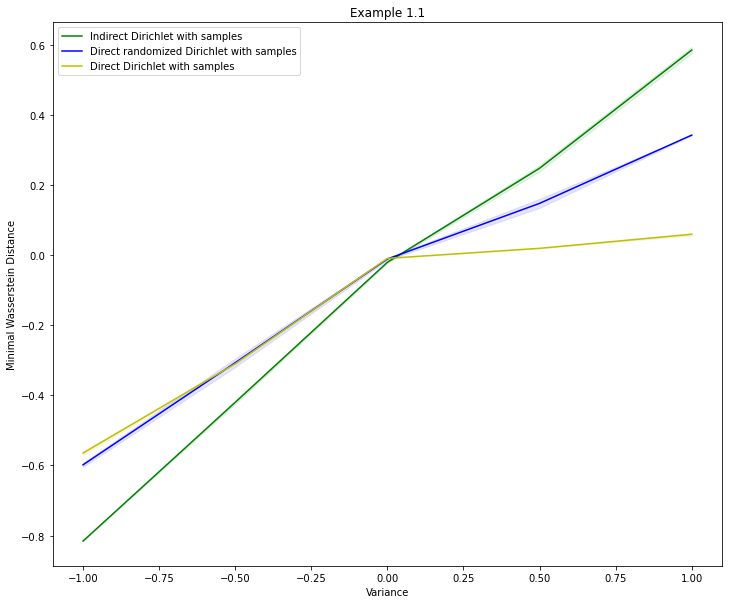

In [ ]:
# Plot three curves in one graph

# Plotting the curves simultaneously
pl.plot(x, y_samples, color='g', label='Indirect Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_samples, ci_upper_samples, color='g', alpha=.1)
pl.plot(x, y_dir, color='b', label='Direct randomized Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_dir, ci_upper_dir, color='b', alpha=.1)
pl.plot(x, y_dir_alt, color='y', label='Direct Dirichlet with samples')
# confidence band
pl.fill_between(x, ci_lower_dir_alt, ci_upper_dir_alt, color='y', alpha=.1)

# Naming the x-axis, y-axis and the whole graph
pl.xlabel("Displacement parameter s")
pl.ylabel("Value function")
pl.title("Example 4.3")

# Adding legend
pl.legend()

# To load the display window
pl.show()

### Runtime Comparison

We now compare the average runtime for each of the optimization methods with repect to each of the examples.

In [ ]:
# Example 1.1
ex1_mr_hist = hist_method_time.mean()
ex1_var_hist = hist_method_time.var()
ex1_mr_samples = samples_method_time.mean()
ex1_var_samples = samples_method_time.var()
ex1_mr_dir = dir_method_time.mean()
ex1_var_dir = dir_method_time.var()
ex1_mr_dir_alt = dir_alt_time.mean()
ex1_var_dir_alt = dir_alt_time.var()

# Example 1.2
ex2_mr_samples = samples_method_time_2.mean()
ex2_var_samples = samples_method_time_2.var()
ex2_mr_dir = dir_method_time_2.mean()
ex2_var_dir = dir_method_time_2.var()
ex2_mr_dir_alt = dir_alt_time_2.mean()
ex2_var_dir_alt = dir_alt_time_2.var()

# Example 2.1
ex3_mr_hist = hist_method_time_3.mean()
ex3_var_hist = hist_method_time_3.var()
ex3_mr_samples = samples_method_time_3.mean()
ex3_var_samples = samples_method_time_3.var()
ex3_mr_dir = dir_method_time_3.mean()
ex3_var_dir = dir_method_time_3.var()
ex3_mr_dir_alt = dir_alt_time_3.mean()
ex3_var_dir_alt = dir_alt_time_3.var()

# Example 2.2
ex4_mr_samples = samples_method_time_4.mean()
ex4_var_samples = samples_method_time_4.var()
ex4_mr_dir = dir_method_time_4.mean()
ex4_var_dir = dir_method_time_4.var()
ex4_mr_dir_alt = dir_alt_time_4.mean()
ex4_var_dir_alt = dir_alt_time_4.var()


In [ ]:
# print results

print("For Ex 4.1 for d=1, the respective average runtime for each method in the order of 'hist', 'samples', 'dirichlet', and 'dirichlet_alt' is: ", ex1_mr_hist, ",", ex1_mr_samples, ",", ex1_mr_dir,",", ex1_mr_dir_alt)
print("The respective variance is ", ex1_var_hist, ",", ex1_var_samples, ",", ex1_var_dir,",", ex1_var_dir_alt)
print("\n")
print("For Ex 4.1 for d=2, the respective average runtime for each method in the order of 'samples', 'dirichlet', and 'dirichlet_alt' is: ", ex2_mr_samples, ",", ex2_mr_dir,",", ex2_mr_dir_alt)
print("The respective variance is ", ex2_var_samples, ",", ex2_var_dir,",", ex2_var_dir_alt)
print("\n")
print("For Ex 4.2, the respective average runtime for each method in the order of 'hist', 'samples', 'dirichlet', and 'dirichlet_alt' is: ", ex3_mr_hist, ",", ex3_mr_samples, ",", ex3_mr_dir,",", ex3_mr_dir_alt)
print("The respective variance is ", ex3_var_hist, ",", ex3_var_samples, ",", ex3_var_dir,",", ex3_var_dir_alt)
print("\n")
print("For Ex 4.3, the respective average runtime for each method in the order of 'samples', 'dirichlet', and 'dirichlet_alt' is: ", ex4_mr_samples, ",", ex4_mr_dir,",", ex4_mr_dir_alt)
print("The respective variance is ", ex4_var_samples, ",", ex4_var_dir,",", ex4_var_dir_alt)

NameError: ignored

We print the table of average runtime comparison: 

In [ ]:
# Table for runtime mean

#create data
data = [["Ex 4.1, d=1", ex1_mr_hist, ex1_mr_samples, ex1_mr_dir, ex1_mr_dir_alt], 
        ["Ex 4.1, d=2", "-", ex2_mr_samples, ex2_mr_dir, ex2_mr_dir_alt], 
        ["Ex 4.2", ex3_mr_hist, ex3_mr_samples, ex3_mr_dir, ex3_mr_dir_alt], 
        ["Ex 4.3", "-", ex4_mr_samples, ex4_mr_dir, ex4_mr_dir_alt]]
  
#define header names
col_names = ["Example", "'Indirect Hist'", "'Indirect Samples'", "'Direct Random Dirichlet'", "'Direct Dirichlet'"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════╤════════════════════╤═════════════╤═══════════════════╤═══════════════╕
│ Example   │ 'Hist'             │   'Samples' │   'Direct Random' │   'Dirichlet' │
╞═══════════╪════════════════════╪═════════════╪═══════════════════╪═══════════════╡
│ Ex 1.1    │ 0.6157270431518554 │     80.9292 │           83.2066 │       82.5965 │
├───────────┼────────────────────┼─────────────┼───────────────────┼───────────────┤
│ Ex 1.2    │ -                  │     84.3312 │           88.0385 │       87.8219 │
├───────────┼────────────────────┼─────────────┼───────────────────┼───────────────┤
│ Ex 2.1    │ 0.6157270431518554 │     80.9292 │           83.2066 │       82.5965 │
├───────────┼────────────────────┼─────────────┼───────────────────┼───────────────┤
│ Ex 2.2    │ -                  │     80.9292 │           83.2066 │       82.5965 │
╘═══════════╧════════════════════╧═════════════╧═══════════════════╧═══════════════╛


We then print the table of runtime variance comparison: 

In [ ]:
# Table for runtime variance

#create data
data = [["Ex 4.1, d=1", ex1_var_hist, ex1_var_samples, ex1_var_dir, ex1_var_dir_alt], 
        ["Ex 4.1, d=2", "-", ex2_var_samples, ex2_var_dir, ex2_var_dir_alt], 
        ["Ex 4.2", ex3_var_hist, ex3_var_samples, ex3_var_dir, ex3_var_dir_alt], 
        ["Ex 4.3", "-", ex4_var_samples, ex4_var_dir, ex4_var_dir_alt]]
  
#define header names
col_names = ["Example", "'Indirect Hist'", "'Indirect Samples'", "'Direct Random Dirichlet'", "'Direct Dirichlet'"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════╤═══════════════════════╤═════════════╤═══════════════════╤═══════════════╕
│ Example   │ 'Hist'                │   'Samples' │   'Direct Random' │   'Dirichlet' │
╞═══════════╪═══════════════════════╪═════════════╪═══════════════════╪═══════════════╡
│ Ex 1.1    │ 0.0008853116736781887 │    0.399598 │          1.73487  │     0.482995  │
├───────────┼───────────────────────┼─────────────┼───────────────────┼───────────────┤
│ Ex 1.2    │ -                     │    0.953965 │          0.161949 │     0.0643403 │
├───────────┼───────────────────────┼─────────────┼───────────────────┼───────────────┤
│ Ex 2.1    │ 0.0008853116736781887 │    0.399598 │          1.73487  │     0.482995  │
├───────────┼───────────────────────┼─────────────┼───────────────────┼───────────────┤
│ Ex 2.2    │ -                     │    0.399598 │          1.73487  │     0.482995  │
╘═══════════╧═══════════════════════╧═════════════╧═══════════════════╧═══════════════╛


We also plot the average runtime for four methods across the four examples.

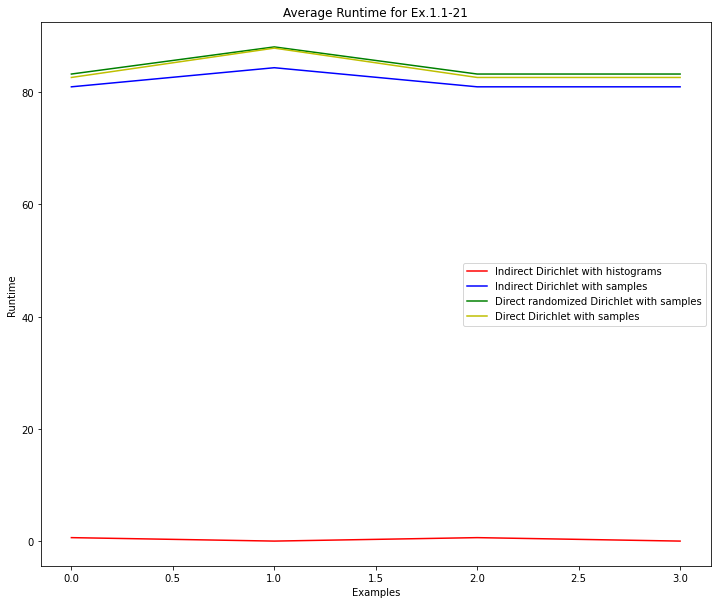

In [ ]:
# plot average runtime 

X = np.arange(4) # corresponds to each example 1.1 - 2.1

# create mean runtime list
hist_method_time = [ex1_mr_hist,0,ex3_mr_hist,0] # fill empty space with 0
samples_method_time = [ex1_mr_samples,ex2_mr_samples,ex3_mr_samples,ex4_mr_samples]
dir_method_time = [ex1_mr_dir,ex2_mr_dir,ex3_mr_dir,ex4_mr_dir]
dir_alt_time = [ex1_mr_dir_alt,ex2_mr_dir_alt,ex3_mr_dir_alt,ex4_mr_dir_alt] 

# Plotting the curves simultaneously
pl.plot(X, hist_method_time, color='r', label='Indirect Dirichlet with histograms')
pl.plot(X, samples_method_time, color='b', label='Indirect Dirichlet with samples')
pl.plot(X, dir_method_time, color='g', label='Direct randomized Dirichlet with samples')
pl.plot(X, dir_alt_time, color='y', label='Direct Dirichlet with samples')

# Naming the x-axis, y-axis and the whole graph
pl.xlabel("Examples")
pl.ylabel("Runtime")
pl.title("Average Runtime for Ex.4.1-4.3")

# Adding legend
pl.legend()

# To load the display window
pl.show()

We also plot the runtime variance for the four methods across the four toy examples for the sake of visuals.

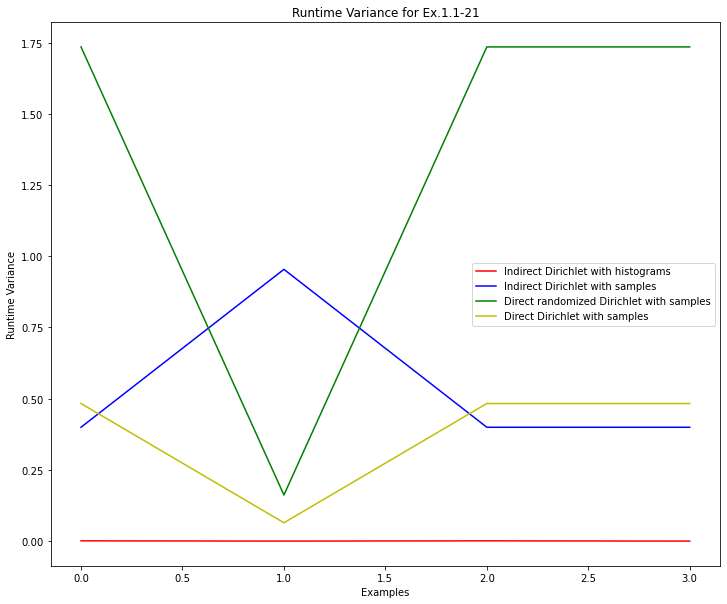

In [ ]:
# plot variance 

# create variance list
hist_method_var = [ex1_var_hist,0,ex3_var_hist,0] # fill empty space with 0
samples_method_var = [ex1_var_samples,ex2_var_samples,ex3_var_samples,ex4_var_samples]
dir_method_var = [ex1_var_dir,ex2_var_dir,ex3_var_dir,ex4_var_dir]
dir_alt_var = [ex1_var_dir_alt,ex2_var_dir_alt,ex3_var_dir_alt,ex4_var_dir_alt]

# Plotting the curves simultaneously
pl.plot(X, hist_method_var, color='r', label='Indirect Dirichlet with histograms')
pl.plot(X, samples_method_var, color='b', label='Indirect Dirichlet with samples')
pl.plot(X, dir_method_var, color='g', label='Direct randomized Dirichlet with samples')
pl.plot(X, dir_alt_var, color='y', label='Direct Dirichlet with samples')

# Naming the x-axis, y-axis and the whole graph
pl.xlabel("Examples")
pl.ylabel("Runtime Variance")
pl.title("Runtime Variance for Ex.4.1-4.3")

# Adding legend
pl.legend()

# To load the display window
pl.show()

### Conclusion

All estimators seem to detect convex order. The "Direct Dirichlet" method however does not seem to explore the $\mathcal{P}_1^2(\mathbb{R}^d)$-space very well in the case that $\mu\preceq_c\nu$, as the value of $V(\mu,\nu)$ stays close to zero then. This is why we also implemented the "Direct randomized Dirichlet" method, which shows an improvement in this regard. When histograms can be easily computed for $\mu,\nu$ and $\rho$, then this seems to reduce the numerical error significantly and yields the most convincing results. However, working on samples directly might more convenient for practical applications on real data.

As can be expected from the numerical implementation, the histogram method consistently yields the lowest runtimes, while runtimes of the other three methods remain well higher. Indeed, when working with samples, the weights $\mu,\rho, \nu$ are constant, while the cost matrices $M_\mu$ and $M_\nu$ have to re-computed in each iteration and this is very costly; for histograms the weights $\rho$ change, while the grid and thus $M_\mu$ and $M_\nu$ stay constant.